## dev cells

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '/gpfs/users/home/fakoed/qm_inorganics/notebook_edvin/git/autoadsorbate/')

from autoadsorbate.autoadsorbate import Surface, Fragment
from ase.io import read, write
from ase.visualize import view
from ase.visualize.plot import plot_atoms

import inspect
inspect.getabsfile(Surface)

'/gpfs/users/home/fakoed/qm_inorganics/notebook_edvin/git/autoadsorbate/autoadsorbate/autoadsorbate.py'

## autoadsorbate

The challenge of generating initial structures for heterogeneous catalysis is traditionally addressed through manual labor. However, this package aims to offer an alternative approach.

To effectively simulate reactive behavior at surfaces, it is crucial to establish clear definitions within our framework. The following definitions are essential in order to accurately characterize the structures of interest:

- __Fragment__: 
    - <font color='red'>Molecules</font> - species that exist in their corresponding geometries __even when isolated from the surface__.
    - <font color='red'>Reactive species</font> - species that exist in their corresponding geometries __only when attached to the surface__.
- __Surface__:
    - The definition of the surface is simple - <font color='red'>every atom of the slab that can be in contact with an intermediate is considered a surface atom</font>. The surface is a collection of such atoms.
    - Every atom of the surface is a "top" site.
    - When two "top" sites are close (close in its literal meaning) to each other, they form a "bridge" site.
    - When three "top" sites are close (close in its literal meaning) to each other, they form a "3-fold" site.
    - etc.
- __Active Site__:
    - A collection of one or more sites that can facilitate a chemical transformation is called an active site.
    - A "top" site can be an active site only for Eley-Rideal transformations.
    - All other transformations require that at least one intermediate binds through at least two sites. All involved sites compose an active site.
- __Intermediate__:
    - Intermediates are fragments bound to an active site.

<!-- ### basic imports -->

the idea was to keep the package as light as possible, hence the foundation of this package is ase and rdkit, allong with some basic python packages (pandas, numpy, etc.)

In [2]:
# from autoadsorbate.autoadsorbate import Surface, Fragment
# from ase.io import read, write
# from ase.visualize import view
# from ase.visualize.plot import plot_atoms
# import matplotlib.pyplot as plt

### Fragment

#### Molecules

In [3]:
f = Fragment(smile = 'COC', to_initialize = 5)

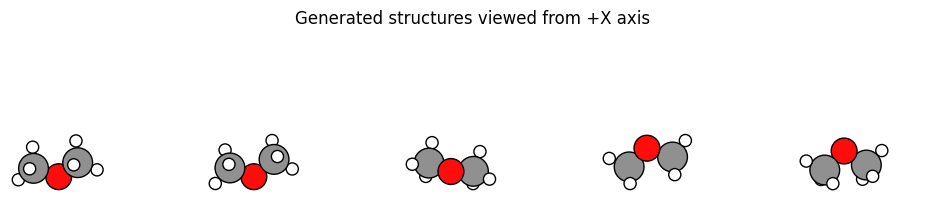

In [4]:
from autoadsorbate.utils import docs_plot_conformers
conformer_trajectory = f.conformers
fig = docs_plot_conformers(conformer_trajectory)

Notice that the orientation of the fragment is arbitrary. We could simply paste these structures on a surface of some material, but it would be difficult to quantify the quality of the initial random guesses and hence how many structures we need to sample. We would then have to run dynamic simulations to probe for local minima and check which minima are the most stable.

In this case of DME, we can use our knowledge of chemistry to simplify the problem. Since the O atom bridging the two methyl groups had 2 "lone electron pairs," we can use a simple trick: replacing one of the lone pairs with a marker atom (let's use Cl).


Notice that we had to make two adjustments to the SMILES string:
- to be able to replace the lone pair with a marker we must "trick" the valnce of the O atom, and reshufle the smiles formula so that the marker is in first place (for easy book-keeping)
    - ```COC``` original
    - ```CO(Cl)C``` add Cl instead of the O lone pair (this is an invalid SMILES)
    - ```C[O+](Cl)C``` trick to make the valence work
    - ```Cl[O+](C)C``` rearrange so taht the SMILES string starts with the marker first (for easy book keeping)

This can be also done with a function:

In [5]:
from autoadsorbate.Smile import get_marked_smiles
marked_smile = get_marked_smiles(['COC'])[0]
marked_smile

'Cl[O+](C)(C)'

In [6]:
f = Fragment(smile = 'Cl[O+](C)(C)', to_initialize = 5)
len(f.conformers)

5

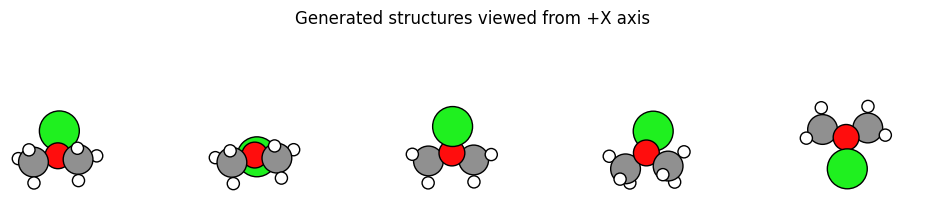

In [7]:
from autoadsorbate.utils import docs_plot_conformers
conformer_trajectory = f.conformers
fig = docs_plot_conformers(conformer_trajectory)

Now we can use the marker atom to orient our molecule:

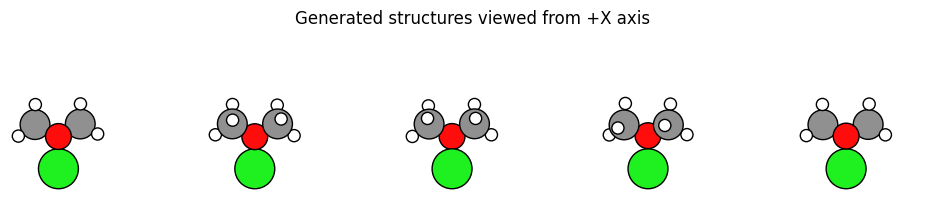

In [8]:
from autoadsorbate.utils import docs_plot_sites

oriented_conformer_trajectory = [f.get_conformer(i) for i, _ in enumerate(f.conformers)]
fig = docs_plot_conformers(oriented_conformer_trajectory)

We can also easily remove the marker:

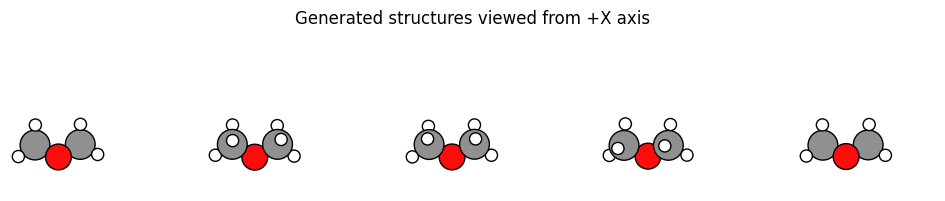

In [9]:
clean_conformer_trajectory = [atoms[1:] for atoms in oriented_conformer_trajectory]
fig = docs_plot_conformers(clean_conformer_trajectory)

#### Reactive species 

Methoxy

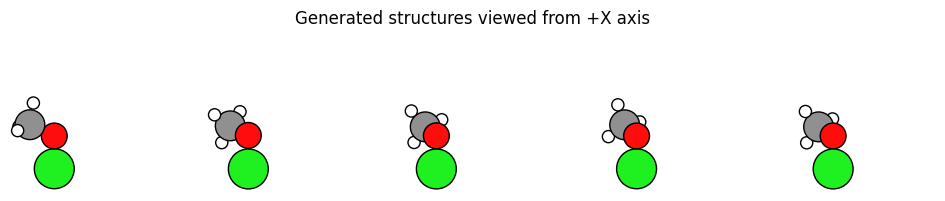

In [10]:
f = Fragment(smile = 'ClOC', to_initialize = 5)
oriented_conformer_trajectory = [f.get_conformer(i) for i, _ in enumerate(f.conformers)]
fig = docs_plot_conformers(oriented_conformer_trajectory)

##### Methyl

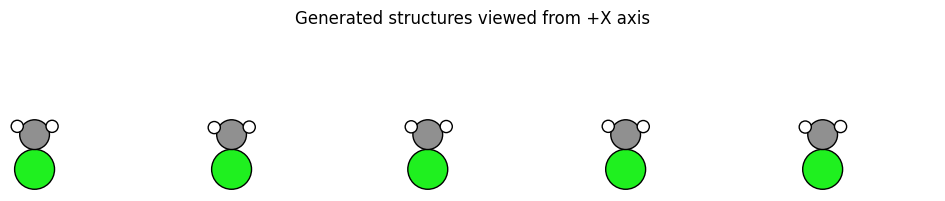

In [11]:
f = Fragment(smile = 'ClC', to_initialize = 5)
oriented_conformer_trajectory = [f.get_conformer(i) for i, _ in enumerate(f.conformers)]
fig = docs_plot_conformers(oriented_conformer_trajectory)

##### Frangments with more than one binding mode (e.g. 1,2-PDO)

bound through single site:

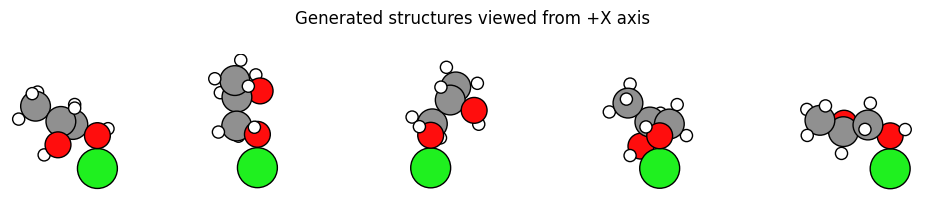

In [12]:
f = Fragment(smile = 'Cl[OH+]CC(O)C', to_initialize = 5)
oriented_conformer_trajectory = [f.get_conformer(i) for i, _ in enumerate(f.conformers)]
fig = docs_plot_conformers(oriented_conformer_trajectory)

Coordinated withboth hydroxil:

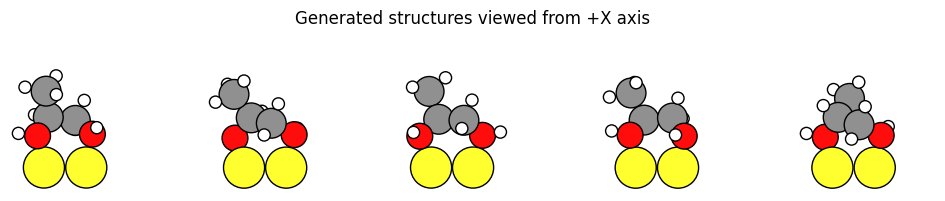

In [13]:
f = Fragment(smile = 'S1S[OH+]CC([OH+]1)C', to_initialize = 5)
oriented_conformer_trajectory = [f.get_conformer(i) for i, _ in enumerate(f.conformers)]
fig = docs_plot_conformers(oriented_conformer_trajectory)

### Surface

First we need to have a slab (slab is an arrangement of atoms that contains the boundry between the material in question and other - i.e. gas, fluid, other material). We can read one (```ase.io.read('path_to_file')```) we prepared earlier, or we can use ase to construct a new slab:

In [14]:
from ase.build import fcc111
slab = fcc111('Cu', (4,4,4), periodic=True, vacuum=10)

Now we can initalize the Surface object which associates the constructed slab (ase.Atoms) with additional information required for placing Fragments.
We can view which atoms are in the surface:

Visualizing surface Cu atoms as Zn


<Axes: >

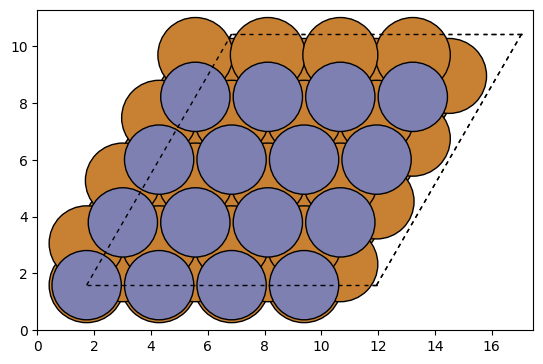

In [15]:
s = Surface(slab)
plot_atoms(s.view_surface(return_atoms=True))

We have access to all the sites info as a pandas dataframe:

In [16]:
s.site_df.head()

,coordinates,connectivity,topology,n_vector,h_vector,site_formula
0,"[0.0, 0.0, 16.252703415323644]",1,[48],"[-0.004670396521231514, -0.0031449903964026822...","[1.0, 0.0, 0.0]",{'Cu': 1}
1,"[0.6381638700208592, 1.105332246430909, 16.252...",2,"[48, 52]","[0.0006776311857337964, -0.010516809475472271,...","[-0.5000000000000001, -0.8660254037844387, 0.0]",{'Cu': 2}
2,"[1.2763277400417168, 5.162938145598479e-16, 16...",2,"[48, 49]","[-0.011576660085263627, -0.017987208564805915,...","[-1.0, 0.0, 0.0]",{'Cu': 2}
3,"[1.2763277400417183, 0.7368881642872727, 16.25...",3,"[48, 49, 52]","[-0.01272989568588465, 0.0042077202541598024, ...","[-0.5000000000000001, -0.8660254037844387, 0.0]",{'Cu': 3}
4,"[1.2763277400417183, 2.210664492861818, 16.252...",1,[52],"[0.0013334161774154326, -0.007734740595549886,...","[1.0, 0.0, 0.0]",{'Cu': 1}


or in dict form:

In [17]:
s.site_dict.keys()

dict_keys(['coordinates', 'connectivity', 'topology', 'n_vector', 'h_vector', 'site_formula'])

One can easily get access to sites ase.Atoms and find useful information in the ase.Atoms.info:

In [18]:
site_atoms = s.view_site(0, return_atoms=True)
site_atoms.info

{'coordinates': array([ 0.        ,  0.        , 16.25270342]),
 'connectivity': 1,
 'topology': [48],
 'n_vector': array([-0.0046704 , -0.00314499,  0.99998415]),
 'h_vector': array([1., 0., 0.]),
 'site_formula': {'Cu': 1}}

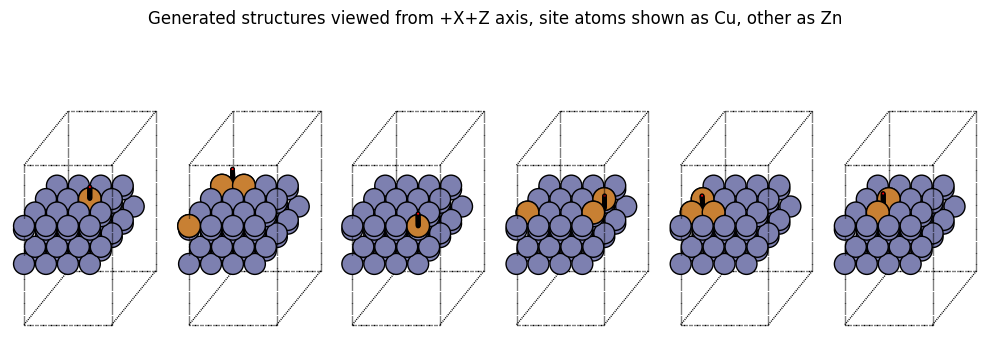

In [19]:
from autoadsorbate.utils import docs_plot_sites
fig = docs_plot_sites(s)

We can keep only the symmetry unique ones like this:

In [20]:
s.sym_reduce()
s.site_df

,coordinates,connectivity,topology,n_vector,h_vector,site_formula
0,"[0.0, 0.0, 16.252703415323644]",1,[48],"[-0.004670396521231514, -0.0031449903964026822...","[1.0, 0.0, 0.0]",{'Cu': 1}
1,"[0.6381638700208592, 1.105332246430909, 16.252...",2,"[48, 52]","[0.0006776311857337964, -0.010516809475472271,...","[-0.5000000000000001, -0.8660254037844387, 0.0]",{'Cu': 2}
3,"[1.2763277400417183, 0.7368881642872727, 16.25...",3,"[48, 49, 52]","[-0.01272989568588465, 0.0042077202541598024, ...","[-0.5000000000000001, -0.8660254037844387, 0.0]",{'Cu': 3}
8,"[2.552655480083436, 1.4737763285745453, 16.252...",3,"[49, 52, 53]","[-0.0011596349368944389, -0.001445905668587753...","[0.5000000000000002, -0.8660254037844385, 0.0]",{'Cu': 3}


Visualizing surface Cu atoms as Zn


<Axes: >

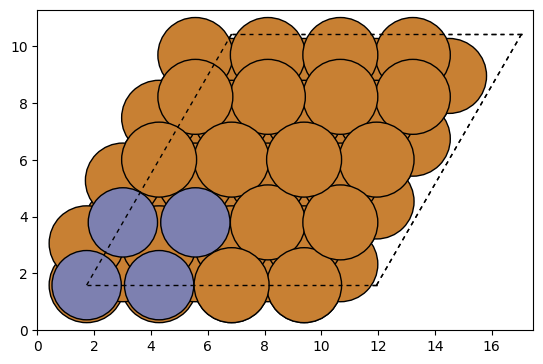

In [21]:
plot_atoms(s.view_surface(return_atoms=True))

## Making surrgate smiles automatically

In [22]:
from autoadsorbate.string_utils import _example_config
_example_config

{'backbone_info': {'C': 1, 'N': 0, 'O': 2},
 'allow_intramolec_rings': True,
 'ring_marker': 2,
 'side_chain': ['(', ')'],
 'brackets': ['[', ']', 'H2]', 'H3]', 'H-]', 'H+]'],
 'make_labeled': True}

In [24]:
from autoadsorbate.string_utils import construct_smiles
 
config = {
'backbone_info': {'C': 0, 'O': 0, 'N':2},
'allow_intramolec_rings': True,
'ring_marker': 2,
'side_chain': ['(', ')'],
'brackets': ['[', ']', 'H+]', 'H2+]', 'H3+]'],
'make_labeled': True
}

smiles = construct_smiles(config)

In [25]:
smiles

['ClNN',
 'Cl[N]N',
 'Cl[NH+]N',
 'Cl[NH2+]N',
 'ClN[N]',
 'ClN[NH+]',
 'ClN[NH2+]',
 'ClN[NH3+]',
 'Cl[N][N]',
 'Cl[N][NH+]',
 'Cl[N][NH2+]',
 'Cl[N][NH3+]',
 'Cl[NH+][N]',
 'Cl[NH+][NH+]',
 'Cl[NH+][NH2+]',
 'Cl[NH+][NH3+]',
 'Cl[NH2+][N]',
 'Cl[NH2+][NH+]',
 'Cl[NH2+][NH2+]',
 'Cl[NH2+][NH3+]',
 'S1SN1N',
 'S1SNN1',
 'S1S[N]N1',
 'S1S[NH+]1N',
 'S1S[NH+]N1',
 'S1S[NH2+]N1',
 'S1SN1[N]',
 'S1SN1[NH+]',
 'S1SN1[NH2+]',
 'S1SN1[NH3+]',
 'S1S[N][N]1',
 'S1S[N][NH+]1',
 'S1S[N][NH2+]1',
 'S1S[NH+]1[N]',
 'S1S[NH+]1[NH+]',
 'S1S[NH+][NH+]1',
 'S1S[NH+]1[NH2+]',
 'S1S[NH+][NH2+]1',
 'S1S[NH+]1[NH3+]',
 'S1S[NH2+][NH2+]1',
 'ClN=N',
 'Cl[NH+]=N',
 'ClN=[N]',
 'ClN=[NH+]',
 'ClN=[NH2+]',
 'Cl[NH+]=[N]',
 'Cl[NH+]=[NH+]',
 'Cl[NH+]=[NH2+]',
 'S1SN=N1',
 'S1S[NH+]=N1',
 'S1S[NH+]=[NH+]1',
 'S1SN1#N']

In [26]:
from autoadsorbate import Fragment
 
trj = []
for s in smiles:
    try:
        f = Fragment(s, to_initialize=1)
        a = f.get_conformer(0)
        trj.append(a)
    except:
        pass
 
lst = [z for z in zip([a.get_chemical_formula() for a in trj],trj)]
lst.sort(key=lambda tup: tup[0])
trj =  [a[1] for a in lst]
len(trj)

52

In [27]:
from autoadsorbate.utils import get_drop_snapped
 
xtrj = get_drop_snapped(trj, d_cut=1.5)
len(xtrj)

33

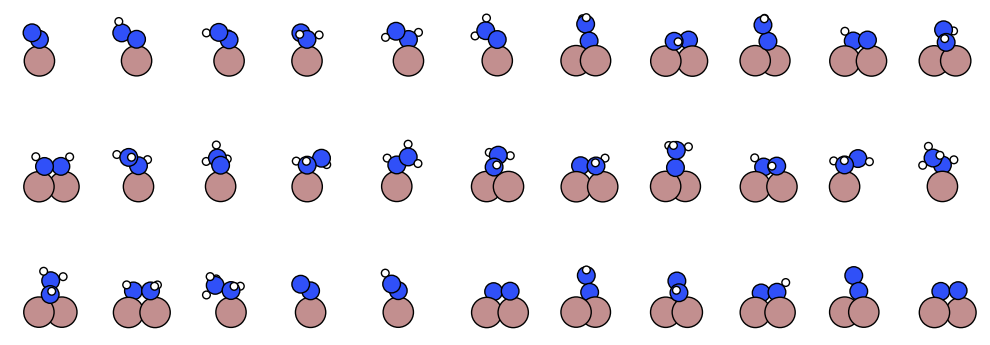

In [31]:
import matplotlib.pyplot as plt
from ase.visualize.plot import plot_atoms
from ase import Atoms
 
fig, axs = plt.subplots(3,11, figsize=[10,5], dpi=100)
 
for i, ax in enumerate(axs.flatten()):
    try:
        platoms = xtrj[i].copy()
         
    except:
        platoms = Atoms('X', positions = [[0,0,0]])
 
    for atom in platoms:
        if atom.symbol in ['Cl', 'S']:
            atom.symbol = 'Ga'
    plot_atoms(platoms, rotation=('-90x,0y,0z'), ax=ax)
    ax.set_axis_off()
    ax.set_xlim(-1, 5)
    ax.set_ylim(-0.5, 5.5)
 
fig.set_layout_engine(layout='tight')

## Fully automatic - populate Surface with Fragment

In [32]:
from ase.build import fcc211
from autoadsorbate.autoadsorbate import Surface, Fragment

slab = fcc211(symbol = 'Cu', size=(6,3,3), vacuum=10)
s=Surface(slab, touch_sphere_size=2.7)
s.sym_reduce()

fragments = [
    Fragment('S1S[OH+]CC(N)[OH+]1', to_initialize=20),
    Fragment('Cl[OH+]CC(=O)[OH+]', to_initialize=5)
]

out_trj = []
for  fragment in fragments:
    out_trj += s.get_populated_sites(fragment, site_index='all', sample_rotation=True, mode='heuristic',
                                     conformers_per_site_cap=5, overlap_thr=1.6, verbose=True)
    print('out_trj ', len(out_trj))

conformers 40
sites 9
SUCCESS! Found the requested numer of conformers with condition: ovelap_thr = 1.6. Found 5 / 5.
SUCCESS! Found the requested numer of conformers with condition: ovelap_thr = 1.6. Found 5 / 5.
SUCCESS! Found the requested numer of conformers with condition: ovelap_thr = 1.6. Found 5 / 5.
SUCCESS! Found the requested numer of conformers with condition: ovelap_thr = 1.6. Found 5 / 5.
SUCCESS! Found the requested numer of conformers with condition: ovelap_thr = 1.6. Found 5 / 5.
out_trj  29
conformers 40
sites 3
SUCCESS! Found the requested numer of conformers with condition: ovelap_thr = 1.6. Found 5 / 5.
SUCCESS! Found the requested numer of conformers with condition: ovelap_thr = 1.6. Found 5 / 5.
SUCCESS! Found the requested numer of conformers with condition: ovelap_thr = 1.6. Found 5 / 5.
out_trj  44
